# Computing Stay Locations

In this notebook, we estimate stay locations as described in the [methodological notes](README.md) of this pilot study using [scikit-mobility](https://scikit-mobility.github.io/scikit-mobility/).

In [1]:
import dask.dataframe as dd
import geopandas
import h3
import pandas as pd
import skmob
from dask.distributed import Client
from shapely.geometry import Polygon
from skmob.measures.individual import distance_straight_line
from skmob.preprocessing import clustering, compression, detection, filtering

## Data

In [2]:
# https://papermill.readthedocs.io/en/latest/usage-parameterize.html
DASK_SCHEDULER_ADDRESS = None

NAME = "A"
DATE = "2022-01-01"
YEAR = 2022
QUARTER = 1

In [3]:
client = Client(DASK_SCHEDULER_ADDRESS)

/Users/g4brielvs/.pyenv/versions/miniforge3-latest/envs/datapartnership-syria-economic-monitor/lib/python3.10/site-packages/distributed/node.py:183: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 60123 instead
  warnings.warn(


### Mobility Data

In this step, we import the filtered down panel of longitudinal location data generated by `devices` identified within the proximity of the **Area of Interest**.

In [4]:
PATH = [
    f"../../data/interim/panels/{NAME}",
]

filters = [
    ("year", "=", YEAR),
    ("quarter", "=", QUARTER),
]

Reading with [Dask](https://www.dask.org),

In [5]:
ddf = dd.read_parquet(PATH, filters=filters)

Now, let's convert to a `pandas.DataFrame` and store in memory.

In [6]:
df = ddf.compute()

Finally, the number of observations,

In [7]:
len(df)

3241357

## Trajectory Analysis

### Creating `skmob.TrajDataFrame`

In this step, we leverage [scikit-mobility](https://scikit-mobility.github.io/scikit-mobility/), including its built-in **data structures** `skmob.TrajDataFrame` and `skmob.FlowDataFrame` to analyse the mobile location data. 

In [8]:
tdf = skmob.TrajDataFrame(
    df, latitude="latitude", longitude="longitude", datetime="datetime", user_id="uid"
)

In [9]:
len(tdf)

3241357

### Filtering

In this step, we filter and compress the mobile location data to reduce complexity. 

In [10]:
ftdf = filtering.filter(tdf, max_speed_kmh=250.0)

2023-02-15 17:19:37,999 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
2023-02-15 17:19:38,611 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
2023-02-15 17:19:39,552 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
2023-02-15 17:19:40,085 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
2023-02-15 17:19:41,520 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
2023-02-15 17:19:42,492 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
2023-02-15 17:19:43,305 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
2023-02-15 17:19:43,989 - distributed.utils_perf - WARNING - full garbage collections took

### Stay Locations

In [11]:
stdf = detection.stay_locations(
    ftdf,
    stop_radius_factor=0.5,
    minutes_for_a_stop=20.0,
    spatial_radius_km=0.2,
    leaving_time=True,
)

2023-02-15 17:20:06,512 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2023-02-15 17:20:07,728 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2023-02-15 17:20:08,896 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2023-02-15 17:20:10,299 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2023-02-15 17:20:11,127 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2023-02-15 17:21:05,493 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


```{seealso}
[scikit-mobility Documentation](https://scikit-mobility.github.io/scikit-mobility/reference/preprocessing.html#skmob.preprocessing.detection.stay_locations)
```

### Clustering

In [12]:
cstdf = clustering.cluster(stdf, cluster_radius_km=0.1, min_samples=1)

### Visualizing

#### Stay Locations

In [13]:
cstdf.plot_stops(max_users=10)

Next, we aggregate the stay locations using the [H3](https://h3.geo.org) geospatial indexing system. 

In [15]:
gdf = cstdf.to_geodataframe()

/Users/g4brielvs/.pyenv/versions/miniforge3-latest/envs/datapartnership-syria-economic-monitor/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [16]:
gdf["hexid"] = gdf.apply(lambda x: h3.geo_to_h3(x["lng"], x["lat"], 7), axis="columns")

Aggregating on `hexid` and counting the number of stay location within the corresponding hexagon.

In [17]:
count = gdf.groupby(["hexid"])["uid"].count().to_frame("count")

count["geometry"] = count.index.to_series().apply(
    lambda x: Polygon(h3.h3_to_geo_boundary(x))
)

Visualizing, 

In [18]:
geopandas.GeoDataFrame(
    count,
    geometry="geometry",
    crs="EPSG:4326",
).explore("count", cmap="cividis", scheme="Percentiles")

### Trajectories

We identify the device with the longest travelled distance to visualize and illustrate its trajectory. 

In [22]:
dsl_df = distance_straight_line(cstdf)

100%|████████████████████████████████████████| 176/176 [00:00<00:00, 604.16it/s]


In [ ]:
user = dsl_df.sort_values("distance_straight_line").iloc[-1]["uid"]

Text(0.5, 1.0, 'Diary')

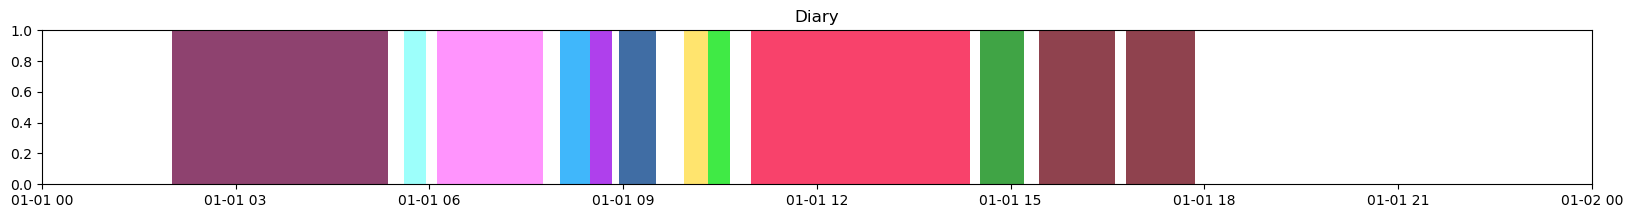

In [36]:
start_datetime = pd.Timestamp("2022-01-01 00:00:00", tz="Asia/Damascus")
end_datetime = pd.Timestamp("2022-01-02 00:00:00", tz="Asia/Damascus")

ax = cstdf.plot_diary(user, start_datetime, end_datetime)
ax.set_title("Diary")